In [53]:
import ee
import IPython.display as disp
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, gamma, f, chi2
import geemap


# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()


Enter verification code: 4/1AX4XfWjfAMelzHmyHoNr8AXkeC6bz5Ewmnijs_4q4KcqGWXEebWCB82BPKU

Successfully saved authorization token.


In [54]:
#defining the area of interest (aoi)
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              116.44019,
              -0.662607
            ],
            [
              116.485106,
              -0.662607
            ],
            [
              116.485106,
              -0.707523
            ],
            [
             116.44019,
              -0.707523
            ],
            [
              116.44019,
              -0.662607
            ]
          ]
        ]
      }
    }
  ]
}

coords = geoJSON['features'][0]['geometry']['coordinates']
aoi = ee.Geometry.Polygon(coords)

In [55]:
import folium
# Define a method for displaying Earth Engine image tiles to folium map for visuallizing
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [56]:
#calling the sentinel 1 images for the two periods from the google earth engine

s1_july = (ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')
                .filterBounds(aoi)
                .filterDate(ee.Date('2019-07-01'),ee.Date('2019-07-10'))
                .sort('system:time_start'))
s1_august = (ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')
                .filterBounds(aoi)
                .filterDate(ee.Date('2019-08-21'),ee.Date('2019-08-30'))
                .sort('system:time_start'))
fe_coll=ee.FeatureCollection('COPERNICUS/S1_GRD_FLOAT')

In [57]:
# to know the date of the image in july
import time
acq_times = s1_july.aggregate_array('system:time_start').getInfo()
[time.strftime('%x', time.gmtime(acq_time/1000)) for acq_time in acq_times]

['07/06/19']

In [58]:
# to know the date of the image in august
acq_times = s1_august.aggregate_array('system:time_start').getInfo()
[time.strftime('%x', time.gmtime(acq_time/1000)) for acq_time in acq_times]

['08/23/19']

In [59]:
#to clip the s1 image of july to the aoi and selset vv and vh bands and clip them to the aoi
s1_july_list= s1_july.toList(s1_july.size())
s1_july_clip =ee.Image(s1_july_list.get(0)).clip(aoi)
vv_july = ee.Image(s1_july_list.get(0)).select('VV').clip(aoi)
vh_july = ee.Image(s1_july_list.get(0)).select('VH').clip(aoi)

In [60]:
#to clip the s1 image of jaugust to the aoi and selset vv and vh bands and clip them to the aoi
s1_august_list = s1_august.toList(s1_august.size())
s1_august_clip =ee.Image(s1_august_list.get(0)).clip(aoi)
vv_august = ee.Image(s1_august_list.get(0)).select('VV').clip(aoi)
vh_august= ee.Image(s1_august_list.get(0)).select('VH').clip(aoi)

In [61]:
#creating Radar Forest Degradtion Index for july and august
#Radar Forest Degradtion Index = (VV-VH)/(VV+VH)
like= 'VV'
cross = 'VH'
rfdi_july = s1_july_clip.normalizedDifference([like, cross])
rfdi_august= s1_august_clip.normalizedDifference([like, cross])

In [62]:
#get the information of radar forest degredation index
rfdi_july.bandNames().getInfo()
rfdi_august.bandNames().getInfo()

['nd']

In [63]:
# histogram of the radar forest degredation index for july and august
hist_july = rfdi_july.select('nd').reduceRegion(
    ee.Reducer.fixedHistogram(0, 1, 500),aoi).get('nd').getInfo()

hist_august = rfdi_august.select('nd').reduceRegion(
    ee.Reducer.fixedHistogram(0, 1, 500),aoi).get('nd').getInfo()


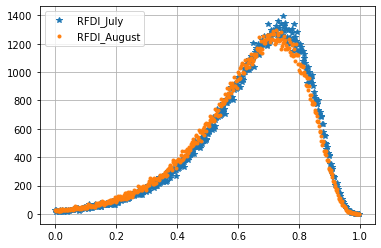

In [64]:
#displaying the histogram 
a = np.array(hist_july)
b = np.array(hist_august)
x = a[:, 0]                
y = a[:, 1] 
x1 = b[:, 0]                
y1= b[:, 1]
plt.grid()
plt.plot(x, y,'*',label='RFDI_July')
plt.plot(x1,y1,'.',label= 'RFDI_August')
plt.legend()
plt.show()

In [65]:
# visualizing the radar forest degredation index for july 
url = rfdi_july.getThumbURL({'min': 0.0, 'max': 1})
disp.Image(url=url, width=500)

In [66]:
# visualizing the radar forest degredation index for august 
url = rfdi_august.getThumbURL({'min': 0.0, 'max': 1})
disp.Image(url=url, width=500)

In [67]:
# the difference between the radar forest degradtion indexes for july and august
difference = rfdi_august.subtract(rfdi_july)
url = difference.getThumbURL({'min': -1, 'max': 1})
disp.Image(url=url, width=500)

In [68]:
#to visualize deforestration regions (july)where RFDI is larger than 0.9 and degradtion regions where RFDI is 0.4 and dense forest regions where RFDI is less than 0.3
rfdi_july_1 = ee.Image(1) \
          .where(rfdi_july .gt(0.0).And(rfdi_july.lte(0.3)), 2) \
          .where(rfdi_july .gt(0.3).And(rfdi_july.lte(0.9)), 3) \
          .where(rfdi_july .gt(0.9), 4)

#display over earth map

location = aoi.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(
    location=location, tiles='Stamen Toner',
    zoom_start=13)
folium.TileLayer('OpenStreetMap').add_to(mp)
mp.add_ee_layer(rfdi_july_1,
                {'min': 0, 'max': 4, 'palette': ['#654321','#FFA500','#FFFF00', '#00FF00', 'red']},
                'Change Map')

mp.add_child(folium.LayerControl())

display(mp)


In [69]:
#to visualize deforestration regions (august) where RFDI is larger than 0.9 and degradtion regions where RFDI is 0.4 and dense forest regions where RFDI is less than 0.3
rfdi_august_1 = ee.Image(1) \
          .where(rfdi_august .gt(0.0).And(rfdi_august.lte(0.3)), 2) \
          .where(rfdi_august .gt(0.3).And(rfdi_august.lte(0.9)), 3) \
          .where(rfdi_august .gt(0.9), 4)

#display over earth map

location = aoi.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(
    location=location, tiles='Stamen Toner',
    zoom_start=13)
folium.TileLayer('OpenStreetMap').add_to(mp)
mp.add_ee_layer(rfdi_august_1,
                {'min': 0, 'max': 4, 'palette': ['#654321','#FFA500','#FFFF00', '#00FF00', 'red']},
                'Change Map')

mp.add_child(folium.LayerControl())

display(mp)

In [70]:
#masking the deforestration regions (july) where RDFI is larger than 0.9
rfdi_july_mask = rfdi_july.updateMask(rfdi_july.gt(0.90))
#visualize the maked map
url = rfdi_july_mask.getThumbURL({'min': 0.90, 'max': 1})
disp.Image(url=url, width=800)

In [71]:
#masking the deforestration regions (august) where RDFI is larger than 0.9
rfdi_august_mask = rfdi_august.updateMask(rfdi_august.gt(0.90))
#visualize the maked map
url = rfdi_august_mask.getThumbURL({'min': 0.90, 'max': 1})
disp.Image(url=url, width=800)

In [72]:
#converting the masked raster to vector (july)
#converting the raster from float to integer
rfdi_july_mask_int = rfdi_july_mask.toInt()
scale_to_use = rfdi_july_mask_int.projection().nominalScale()

rfdi_july_vector = rfdi_july_mask_int.reduceToVectors(
  reducer = ee.Reducer.countEvery(),
  geometry= aoi,
  scale=scale_to_use,
  geometryType= 'centroid',
  labelProperty = 'deforestration',
  eightConnected= False    
)
#getting the information of the vector
rfdi_july_vector.getInfo

<bound method Collection.getInfo of <ee.featurecollection.FeatureCollection object at 0x7f3960cd3f70>>

In [73]:
# Display the vector of deforestration regions in july.
Map = geemap.Map()
Map.addLayer(rfdi_july_vector, {}, 'default display')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [74]:
#converting the masked raster to vector (august)
#converting the raster from float to integer
rfdi_august_mask_int = rfdi_august_mask.toInt()
scale_to_use = rfdi_august_mask_int.projection().nominalScale()

rfdi_august_vector = rfdi_august_mask_int.reduceToVectors(
  reducer = ee.Reducer.countEvery(),
  geometry= aoi,
  scale=scale_to_use,
  geometryType= 'centroid',
  labelProperty = 'deforestration',
  eightConnected= False    
)
#getting the information of the vector
rfdi_august_vector.getInfo

<bound method Collection.getInfo of <ee.featurecollection.FeatureCollection object at 0x7f3960c0a190>>

In [75]:
# Display the vector of deforestration regions in august
Map.addLayer(rfdi_august_vector, {}, 'default display')
Map

Map(bottom=754.0, center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(…

In [76]:
#writting the vector of deforestration regions(july) to the drive in Geojson format

task = ee.batch.Export.table.toDrive(collection= rfdi_july_vector,
                                  description= 'Deforestration in July',
                                  fileFormat= 'GeoJSON')
                                
task.start()

In [77]:
#writting the vector of deforestration regions(august) to the drive in Geojson format

task = ee.batch.Export.table.toDrive(collection= rfdi_august_vector,
                                  description= 'Deforestration in august',
                                  fileFormat= 'GeoJSON')
                                
task.start()

In [78]:
#for validation, NDVI from Sentinel 2 was used
#computing the NDVI
#filtering the sentinel images according to the date and the AOI for july
s2_july = (ee.ImageCollection('COPERNICUS/S2')
        .filterDate('2019-07-01', '2019-07-10')
        .filterBounds(aoi)
        .select('B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12'))
#filtering the sentinel images according to the date and the AOI for august
s2_august = (ee.ImageCollection('COPERNICUS/S2')
        .filterDate('2019-08-21', '2019-08-30')
        .filterBounds(aoi)
        .select('B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12'))


In [79]:
#getting the date of the images after filtering them in july
acq_times = s2_july.aggregate_array('system:time_start').getInfo()
[time.strftime('%x', time.gmtime(acq_time/1000)) for acq_time in acq_times]

['07/05/19']

In [80]:
#getting the date of the images after filtering them in august
acq_times = s2_august.aggregate_array('system:time_start').getInfo()
[time.strftime('%x', time.gmtime(acq_time/1000)) for acq_time in acq_times]

['08/24/19', '08/29/19']

In [81]:
#choosing the image with date 24-08-2019 for the validation 
s2_august_mod = (ee.ImageCollection('COPERNICUS/S2')
        .filterDate('2019-08-21', '2019-08-25')
        .filterBounds(aoi)
        .select('B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12'))
acq_times = s2_august_mod.aggregate_array('system:time_start').getInfo()
[time.strftime('%x', time.gmtime(acq_time/1000)) for acq_time in acq_times]

['08/24/19']

In [82]:
#NDVI compution for july
s2_july_ls = s2_july.toList(s2_july.size())
s2_july_clip =ee.Image(s2_july_ls.get(0)).clip(aoi)
B8_band = ee.Image(s2_july_clip.get(0)).select('B8').clip(aoi) #to display the B8 band
B4_band = ee.Image(s2_july_clip.get(0)).select('B4').clip(aoi) #to display the B4 band
nir_7 = 'B8'
red_7 = 'B4'
ndvi_july = s2_july_clip .normalizedDifference([nir_7, red_7])
#NDVI compution for august
s2_august_ls = s2_august_mod.toList(s2_august_mod.size())
s2_august_clip =ee.Image(s2_august_ls.get(0)).clip(aoi)
nir_8 = 'B8'
red_8 = 'B4'
ndvi_august= s2_august_clip .normalizedDifference([nir_8, red_8])

In [83]:
# getting the band names of the NDVI image of july
ndvi_july.bandNames().getInfo()

['nd']

In [84]:
# getting the band names of the NDVI image of august
ndvi_august.bandNames().getInfo()

['nd']

In [85]:
#display the ndvi of july
url = ndvi_july.getThumbURL({'min': 0, 'max': 1})
disp.Image(url=url, width=500)


In [86]:
#display the ndvi of august
url = ndvi_august.getThumbURL({'min': 0, 'max': 1})
disp.Image(url=url, width=500)


In [121]:
#display true color composit of sentinel 2 image in july
S2_JULY_TRUE = s2_july.median().clip(aoi)

Map.addLayer(S2_JULY_TRUE,{'bands':['B4', 'B3', 'B2'], 'min':1, 'max':2000},
             'true_s2_july')
Map.centerObject(aoi,12)
Map

Map(bottom=1052683.0, center=[-0.6850650175328027, 116.46264800000104], controls=(WidgetControl(options=['posi…

In [130]:
#display true color composit of sentinel 2 image in August
S2_august_TRUE = s2_august_mod.median().clip(aoi)

Map.addLayer(S2_august_TRUE,{'bands':['B4', 'B3', 'B2'], 'min':700, 'max':2000},
             'true_s2_august')
Map.centerObject(aoi,12)
Map

Map(bottom=2105326.0, center=[-0.6850650175328027, 116.46264800000104], controls=(WidgetControl(options=['posi…

In [114]:
#set two points in the aoi to validate
point1 = ee.Geometry.Point([-0.677,116.456])
point2 = ee.Geometry.Point([-0.685,116.456])

pixelInfo = ee.Number((rfdi_july).reduceRegion(
  geometry = point1,
  scale= 100,
  maxPixels= 1e9,
  reducer= ee.Reducer.mean()))

print(pixelInfo .getInfo())



{'nd': None}


In [90]:
#count the deforestration pixels in july
pixel_count_july = ee.Number((rfdi_july_mask).reduceRegion(
  geometry = aoi,
  scale= 10,
    maxPixels= 1e9,
  reducer= ee.Reducer.count()))

pixel_count_july.getInfo()

{'nd': 5567}

In [91]:
#count the deforestration pixels in august
pixel_count_august = ee.Number((rfdi_august_mask).reduceRegion(
  geometry = aoi,
  scale= 10,
    maxPixels= 1e9,
  reducer= ee.Reducer.count()))

pixel_count_august.getInfo()

{'nd': 4606}

In [92]:
#count the degradated pixels in july
#mask the degradated pixels
rfdi_july_mask_2 = rfdi_july.updateMask(rfdi_july.gt(0.30).And(rfdi_july.lt(0.60)))

#count the pixels
pixel_count_july_2 = ee.Number((rfdi_july_mask_2).reduceRegion(
  geometry = aoi,
  scale= 10,
    maxPixels= 1e9,
  reducer= ee.Reducer.count()))

pixel_count_july_2.getInfo()

{'nd': 71098}

In [93]:
#count the degradated pixels in august
#mask the degradated pixels
rfdi_august_mask_2 = rfdi_august.updateMask(rfdi_august.gt(0.30).And(rfdi_august.lt(0.60)))
#count the pixels
pixel_count_august_2 = ee.Number((rfdi_august_mask_2).reduceRegion(
  geometry = aoi,
  scale= 10,
    maxPixels= 1e9,
  reducer= ee.Reducer.count()))

pixel_count_august_2.getInfo()

{'nd': 77121}

In [94]:
#export the sentinel 1 raster for the deforestration in july
task_config = {
                'scale': 30,  
                'fileFormat': 'GeoTIFF',
                'region': aoi
                }

task = ee.batch.Export.image(rfdi_july, 'rfdi_July', task_config)

task.start()

In [95]:
#export the sentinel 1 raster for the deforestration in august
task_config = {
                'scale': 30,  
                'fileFormat': 'GeoTIFF',
                'region': aoi
                }

task = ee.batch.Export.image(rfdi_august, 'rfdi_august', task_config)

task.start()


In [96]:
# histogram of the NDVI for july and august
hist_july_ndvi = ndvi_july.select('nd').reduceRegion(
    ee.Reducer.fixedHistogram(0, 1, 500),aoi).get('nd').getInfo()

hist_august_ndvi = ndvi_august.select('nd').reduceRegion(
    ee.Reducer.fixedHistogram(0, 1, 500),aoi).get('nd').getInfo()

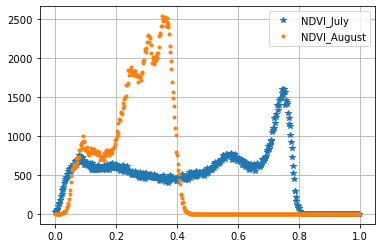

In [97]:
#displaying the histogram 
a = np.array(hist_july_ndvi)
b = np.array(hist_august_ndvi)
x = a[:, 0]                
y = a[:, 1] 
x1 = b[:, 0]                
y1= b[:, 1]
plt.grid()
plt.plot(x, y,'*',label='NDVI_July')
plt.plot(x1,y1,'.',label= 'NDVI_August')
plt.legend()
plt.show()

In [98]:
# choosing two points and calculte the ndvi and rfdi foe them
#point1=(-0.658,116.457)
#point2= (-0.699,116.478)
from PIL import Image

im_rfdi_july = Image.open(r"///home/ayat/Downloads/rfdi_July.tif")
im_rfdi_august = Image.open(r"///home/ayat/Downloads/rfdi_august.tif")
im_ndvi_july = Image.open(r"///home/ayat/Downloads/NDVI_July.tif")
im_ndvi_august = Image.open(r"///home/ayat/Downloads/NDVI_august.tif")
px1 = im_rfdi_july.load()
px2 = im_rfdi_august.load()
px3 = im_ndvi_july.load()
px4 = im_ndvi_august.load()
coordinate1 = x, y = -0.658, 116.45

#point1
print (im_rfdi_july.getpixel(coordinate1));
print (im_rfdi_august.getpixel(coordinate1));
print (im_ndvi_july.getpixel(coordinate1));
print (im_ndvi_august .getpixel(coordinate1));


FileNotFoundError: [Errno 2] No such file or directory: '///home/ayat/Downloads/rfdi_July.tif'

In [99]:
coordinate2 = x, y = -0.7, 116.47
#point2
print (im_rfdi_july.getpixel(coordinate2));
print (im_rfdi_august.getpixel(coordinate2));
print (im_ndvi_july.getpixel(coordinate2));
print (im_ndvi_august .getpixel(coordinate2));

NameError: name 'im_rfdi_july' is not defined